# Preprocessing

The goal of this notebook is to create a function that will be able to extract the image urls and specs for each house scraped from Realtor.com.

In [ ]:
# ! pip install ipynb

In [1]:
import pandas as pd
import numpy as np
from bs4 import BeautifulSoup

import json
import re
import os
import requests
import ipynb

In [2]:
# Samantha's Function:
### NOTE: from ipynb.fs.full.prepocessing_ST import extract_images DID NOT WORK FOR ME
### So this means we may have to be more creative with importing notebooks.

#Note: This doesn't take into account exceptions, should prob include that later too

def extract_images(url):
    
    '''
    Input: Takes in a home url address
    Output: Returns list of urls for photo gallery
    '''
    

    headers = {'User-Agent':'Mozilla/5.0 (Macintosh; Intel Mac OS X 10_11_2) \
               AppleWebKit/601.3.11 (KHTML, like Gecko) Version/9.0.2 Safari/601.3.9','Accept-Encoding': 'identity'}

    page = requests.get(URL, headers=headers)
    soup = BeautifulSoup(page.content, 'html.parser')
    html_filtered = soup.find_all('div', attrs={'class': 'background-item'}) 

    image_urls = []
    for e in html_filtered: 
        image_urls += re.findall("(http.*\.jpg|\.png|\.JPG|\.PNG)", str(e))
        
    return image_urls

First, I'm manually inputting some test urls that the scraper will provide. I just took the top 5 listings from a search in Fremont, CA. Then, I'll loop through these with my function to output a dataframe with the relevant information.

In [3]:
test_urls = ['https://www.realtor.com/realestateandhomes-detail/38066-Stenhammer-Dr_Fremont_CA_94536_M26705-99955',
            'https://www.realtor.com/realestateandhomes-detail/120-Fisk-Ter_Fremont_CA_94538_M16383-48817',
            'https://www.realtor.com/realestateandhomes-detail/4267-Michael-Ave_Fremont_CA_94538_M24837-74413',
            'https://www.realtor.com/realestateandhomes-detail/42232-Mission-Blvd_Fremont_CA_94539_M16238-69850',
            'https://www.realtor.com/realestateandhomes-detail/Fremont_CA_94538_M20599-22956']

This function loads all the URLs and outputs a list of BeautifulSoup objects for each one. I made this a separate function because I didn't want to get blocked; this way I only have to ask for the html once and then I have it in the local environment. $\textbf{TODO: }$ We need to update this function to allow it to open thousands of URLs without getting blocked.

In [4]:
#I'm just going to load all the pages first so there's only one request to the site for the five pages

def get_content(urls):
    ## Given a singular url or list of urls, outputs soup objects
    ## This is to prevent a bunch of repeated reqests to Realtor.com
    
    if type(urls) != list:
        urls = [urls]
    
    list_of_soups = []
    
    for url in urls:
        #Load html
        
        # Samantha's Code to get around bot detection:
        # dang, got blocked...
        headers = {'User-Agent':'Mozilla/5.0 (Macintosh; Intel Mac OS X 10_11_2) \
           AppleWebKit/601.3.11 (KHTML, like Gecko) Version/9.0.2 Safari/601.3.9','Accept-Encoding': 'identity'}

        proxies = {
          'http': 'http://119.206.242.196'
        }

        # might have to reroute ip address
        # maybe helpful? https://www.scrapehero.com/how-to-rotate-proxies-and-ip-addresses-using-python-3/

        page = requests.get(url, headers=headers, proxies=proxies)
        soup = BeautifulSoup(page.content, 'html.parser')
        list_of_soups.append(soup)
        
    return list_of_soups

        

This function takes a bunch of BeautifulSoup objects and returns a Dataframe with each image url and the associated information about it such as:
1. The most likely label
2. The probability of that label
3. The Address
4. Price
5. Number of Beds
6. Number of Baths
7. Year Built
8. Property Type 
9. Square footage
10. Garage Spaces (0 if no garage)


In [5]:
def get_images_and_stats(soup_objs, urls):
#       Given a bunch of beautifulsoup objects, outputs a dataframe with image urls
#       and stats of the image 
#       Example:
#       image_url | most_likley_label | probability | address | num_beds | ... |
    
#     Looping through soup objects and urls
    
    result = pd.DataFrame()
    
    for num in np.arange(0, len(soup_objs)):
        i = soup_objs[num]
        url = urls[num]
        
        ###### IMAGE SECTION #####
        
        # Finding image urls
        
        # The area of html that's interesting to us with the probabilities
         
        image_str = re.findall(r'"home_photos":{(.*)}]}]},', str(i))
        image_str = image_str[0] + '}]}]'
        temp = re.findall(r'"href":"(.*?)(\.jpg|\.png|\.JPG|\.PNG)', str(image_str))
        
        # due to re's weird format, we need to combine the tuples
        
        image_urls = []
        for l in temp:
            image_urls.append(str(l[0]) + str(l[1]))
        
        
        # looping through the image urls to find the most propable tag for each one with its 
        # respective probability 
        
        # best_labels is a list with the most likely labels 
        # best_probabilities is the probability for that label. 
        # Order is maintained so this should be mapped pretty 
        # easily to the image_url list when constructing final dataframe
        
        best_labels =[]
        best_probabilities = []
        
        
        for j in image_urls:
            
            # getting relevant portion of the html that pertains to the image_url
            regex_str = j + r"(.*?)]}" 
            probability_str = re.findall(regex_str, str(image_str))
            
            # getting probabilities and labels
            labels = re.findall(r'label":"(.*?)",', str(probability_str))
            probabilities = re.findall(r'probability":(.*?)}', str(probability_str))
            probabilities = [float(k) for k in probabilities]
    
            # creating dataframe to get max probability label
            temp = pd.DataFrame({'labels' : labels, 'probabilities': probabilities})
            temp = temp.sort_values(by = ['probabilities'], ascending = False)
            
            try:
                best_labels.append(temp.iloc[0,0])
            except:
                print(j)
                print(image_str)
                print(probability_str)
                print(probabilities)
                print(labels)
                print(temp)
                raise ValueError("Temp is most likely empty if you're getting this message.")
            best_probabilities.append(temp.iloc[0,1])
            
            
        ###### PROPERTY DETAIL SECTION #######

        # First, let's get the address from the url
        # If there's no address, the entry will appear as 'N/A' or just a portion of the address
        # such as the city and zipcode
            
        address = re.findall(r'https://www.realtor.com/realestateandhomes-detail/(.*)', url)[0]
        
        # I need to make the address fit the dimension of all the images for this house
        address = [address for p in best_labels]
        
        #same as above except accounting for if there's no price found
        try:
            price = re.findall(r'jsx-1959108432 price">\$(.*?)<', str(i))[0]
            price = [int(price.replace(',', '')) for p in best_labels]
        except:
            price = [None for p in best_labels]
            
        # TODO:
        # FINISH ALL OTHER FEATURES
            
        # updating dataframes
        temp2 = pd.DataFrame({'image_url': image_urls, 'label': best_labels, 'probability': best_probabilities,
                             'Address' : address, 'Price': price})   
        result = pd.concat([result, temp2], axis = 0, ignore_index = True)
        
    
    return result




In [7]:
# ONLY CALL THIS ONCE TO PREVENT BEING BLOCKED
# soups = get_content(test_urls)

In [8]:
df = get_images_and_stats(soups, test_urls)
df.head()

,image_url,label,probability,Address,Price
0,https://ap.rdcpix.com/d7b0b0ef57213b43da91b2f1...,house_view,0.987999,38066-Stenhammer-Dr_Fremont_CA_94536_M26705-99955,875000
1,https://ap.rdcpix.com/d7b0b0ef57213b43da91b2f1...,yard,0.527620,38066-Stenhammer-Dr_Fremont_CA_94536_M26705-99955,875000
2,https://ap.rdcpix.com/d7b0b0ef57213b43da91b2f1...,porch,0.822153,38066-Stenhammer-Dr_Fremont_CA_94536_M26705-99955,875000
3,https://ap.rdcpix.com/d7b0b0ef57213b43da91b2f1...,living_room,0.992320,38066-Stenhammer-Dr_Fremont_CA_94536_M26705-99955,875000
4,https://ap.rdcpix.com/d7b0b0ef57213b43da91b2f1...,living_room,0.999825,38066-Stenhammer-Dr_Fremont_CA_94536_M26705-99955,875000


In [9]:
df.shape

(148, 5)

In [10]:

query = df[df['probability'] > .95]

In [11]:
query.shape

(98, 5)

In [12]:
images_for_nn = query[['image_url', 'label']]
images_for_nn.head()

,image_url,label
0,https://ap.rdcpix.com/d7b0b0ef57213b43da91b2f1...,house_view
3,https://ap.rdcpix.com/d7b0b0ef57213b43da91b2f1...,living_room
4,https://ap.rdcpix.com/d7b0b0ef57213b43da91b2f1...,living_room
5,https://ap.rdcpix.com/d7b0b0ef57213b43da91b2f1...,living_room
6,https://ap.rdcpix.com/d7b0b0ef57213b43da91b2f1...,living_room


In [13]:
images_for_nn['label'].value_counts()

living_room     23
bedroom         22
bathroom        13
kitchen         11
house_view       7
dining_room      7
yard             5
garage           3
porch_yard       2
laundry_room     2
porch            1
road_view        1
unknown          1
Name: label, dtype: int64

### Now we neeed to open and convert images into something that a neural net can use.

Please check out the preprocessing_images_PN notebook for a more exploratory and detailed explanation of what's going on because I included a lot of that stuff here just because this was the pipline we were workinking on.

In [14]:
from skimage import io
import skimage
import cv2
from keras.utils import np_utils
import tensorflow as tf
import keras

In [15]:
# !pip install opencv-python
# !pip install keras
# !conda install tensorflow
# !pip install tensorflow-io

In [31]:
# %%writefile preprocess_image.py

try:
    import pandas as pd
    import numpy as np
    from bs4 import BeautifulSoup

    import json
    import re
    import os
    import requests
    import ipynb

    from skimage import io
    import skimage
    import cv2
    from keras.utils import np_utils
    import keras
    import tensorflow as tf
    
    
except:
    print("If you're reading this, some required packages are not installed. Here is a list of the packages required:")
    
    print('opencv-python')
    print('keras')
    print('tensorflow')
    print('tensorflow-io')
    print('ipynb')
    print('pandas')
    print('numpy')
    
    raise ValueError()
    

def preprocess_image(image_urls_df, IMG_SIZE = 100):
    # Given a dataframe with two columns['image_urls', 'label'], reads image urls into pixels, 
    # converts them to grayscale, standardizes the size and shape and returns a numpy array
    # of the converted images ready to be plugged into a keras neural net
    
    # Converted images are of dimensions (num_images, grayscale_x, grayscale_y)
    # where num_images --> number of images in image_urls
    # grayscale_x, grayscale_y --> 2d grid where postion indicates the pixel position
    #                              and the number in that position is the standardized 
    #                              grayscale integer from 0 to 1
    
    # The IMG_SIZE constant is the length of a side in the square that is the 
    # converted image
    # ie the converted size of the images is 25X25 pixels using the default
    # value above
    
    df = image_urls_df.copy()
    df['image_url'] = df['image_url'].apply(lambda x: io.imread(x)).to_numpy()
    
    # Separating data into X and y while maintaining the right shape for the NN
    X = df.drop("label", axis = 1).to_numpy()
    
    # Thinking about including y in the output, but that might mess up the pipeline
    # y = df['label'].to_numpy()
    
    def convert(data):
        # Converts data to be constant size/shape/color 
        # Also put it in the right shape to be put into a neural net
        def change_img(image):
            #image = skimage.color.rgb2gray(image)
            return cv2.resize(image, (IMG_SIZE, IMG_SIZE))
    
        return np.asarray([change_img(i) for i in data])
    
    
    X = np.asarray([convert(i) for i in X])
    
    # Normalizing data to be in range [0,1] as opposed to [0,255]
    X = X / 255
    
    
    return X

In [41]:
prep = preprocess_image(images_for_nn, IMG_SIZE = 100)

In [42]:
prep.shape

(98, 1, 100, 100, 3)

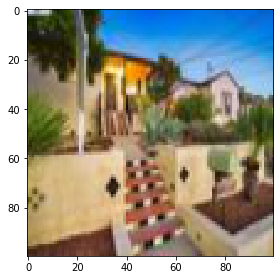

In [43]:
io.imshow(prep[0][0])

In [22]:
img = io.imread(images_for_nn['image_url'][0])

In [24]:
img.shape

(80, 120, 3)

In [26]:
resized = cv2.resize(img, (25,25))

In [28]:
resized.shape

(25, 25, 3)

In [23]:
### Second attempt at above specifically for vgg16

# making copy just for safety
image_df = images_for_nn.copy()


image_df['image'] = image_df['image_url'].apply(lambda x: io.imread(x)).to_numpy()





In [32]:
input_arr = image_df.drop(["label", "image_url"], axis = 1).to_numpy().astype(np.float)

copied = np.copy(input_arr)

print(copied.shape)

preprocessed = tf.keras.applications.vgg16.preprocess_input(copied)
preprocessed.shape

ValueError: setting an array element with a sequence.